# TGDS Model with Feature Engineering

In [1]:
import context
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import src.data.data_preprocessing as util
import src.models.lstm_model as lstm

tf.compat.v1.set_random_seed(1)

### Set Hyperparameters

In [14]:
HYPER_PARAMS =  np.load('../../../models/TGDS/training_setup/hyperparameters.npy', allow_pickle=True)
HYPER_PARAMS = HYPER_PARAMS.item()

# add aditional model-spefic hyperparameters
model_hyperparameters = {
    'n_features': 2,        # number of input features
    'd_t': 0.25,            # current integration factor
    'num_repeat': 1,       # repetition factor for each training profile to create more auxiliary data
}
HYPER_PARAMS.update({'n_lstm_units_1': 200}) # number of LSTM units in the first layer
HYPER_PARAMS.update({'n_lstm_units_2': 100}) # number of LSTM units in the first layer

# update hyperparameters
HYPER_PARAMS.update(model_hyperparameters)

### Prepare Training/Validation/Test Data

In [20]:
TRAINING_SETS =  np.load('../../../models/TGDS/training_setup/training_sets.npy', allow_pickle=True)
TRAINING_SETS = TRAINING_SETS.item()

# select correct training set
training_sets = TRAINING_SETS['10A_all']

train_data = []
for set in training_sets:
    set_repeat = [set] * HYPER_PARAMS['num_repeat']
    train_data += set_repeat
    
train_data = np.array(train_data)

# select first profile for validation
validation_profile = [train_data[0]] 

# select arbitrary profile for testing
test_profile = np.random.choice(train_data, 1) 

# prepare input data
X_train, y_train, scalers_train = util.prepare_current_charge_input(HYPER_PARAMS, train_data, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
X_validation, y_validation, _ = util.prepare_current_charge_input(HYPER_PARAMS, validation_profile, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
X_test, y_test, _ = util.prepare_current_charge_input(HYPER_PARAMS, test_profile, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])

Input: (9350, 100, 2)  Output/Label: (9350, 1)
Input: (1500, 100, 2)  Output/Label: (1500, 1)
Input: (1450, 100, 2)  Output/Label: (1450, 1)


### Initialize and Train Model

In [4]:
lstm = lstm.Model()
lstm.initialize(HYPER_PARAMS)

Model: "Black_Box_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10600     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                5680      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 16,301
Trainable params: 16,301
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
2469/2469 [==============================] - 359s 145ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0306
Epoch 2/5
2469/2469 [==============================] - 358s 145ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0299
Epoch 3/5
2469/2469 [==============================] - 358s 145ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0298
Epoch 4/5
2469/2469 [==============================] - 359s 145ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0297
Epoch 5/5
2469/2469 [==============================] - 360s 146ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0297
Training time: 1795.093s


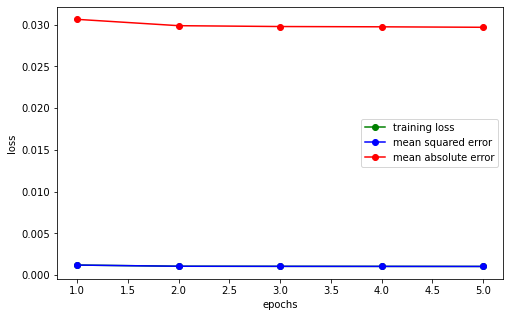

INFO:tensorflow:Assets written to: ../../../models/TGDS/8660\assets


In [5]:
_, fig = lstm.train(X_train, y_train, scalers_train)

# save model and hyperparameters
MODEL_ID = str(np.random.randint(10000))

lstm.model.save('../../../models/TGDS/' + str(MODEL_ID))
np.save('../../../models/TGDS/' + str(MODEL_ID) + '/hyperparameters', HYPER_PARAMS)
fig.savefig('../../../reports/figures/theory_guided_charge-' + str(MODEL_ID) + '-learning_curve.png')

### Test Model

Validation Profile: ['Profile 10A']
Test Profile: ['Profile 10A Run 070618']
2469/2469 [==============================] - 146s 59ms/step
Prediction time on Training Set:  146.138s
47/47 [==============================] - 3s 58ms/step
Prediction time on Validation Set:  2.814s
58/58 [==============================] - 3s 58ms/step
Prediction time on Test Set:  3.457s
###########################################################
            Training    Validation     Test
--------  ----------  ------------  -------
MSE (μV)    119.4         212.4     87.5
MAE (V)       0.0101        0.0143   0.0092
MaxE (V)      0.0243        0.0243   0.0143
###########################################################


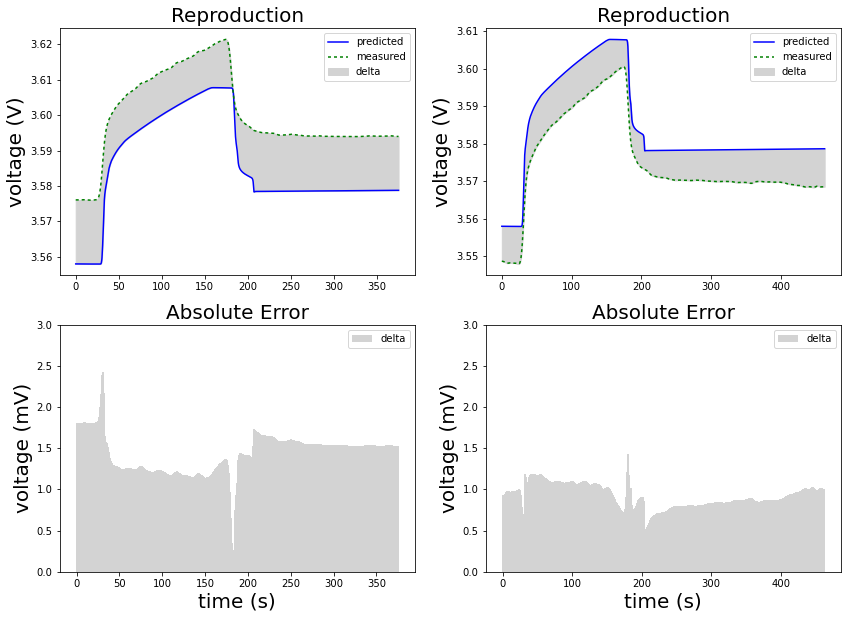

In [6]:
print('Validation Profile:', validation_profile)
print('Test Profile:', test_profile)

yhat_train_unscaled, _, _, _, _, fig = lstm.test(X_train, y_train, X_validation, y_validation, X_test, y_test, scalers_train)

# save plots and predicted sequences
np.save('../../../models/TGDS/' + str(MODEL_ID) + '/predictions', yhat_train_unscaled)
fig.savefig('../../../reports/figures/theory_guided_charge-' + str(MODEL_ID) + '-validation&test_profiles.png')

### Prepare Data for Use Cases

In [16]:
TEST_SETS =  np.load('../../../models/TGDS/training_setup/test_sets.npy', allow_pickle=True)
TEST_SETS = TEST_SETS.item()

test_profiles_usecase_1 = TEST_SETS['Reproduction']
test_profiles_usecase_2 = TEST_SETS['Abstraction']
test_profiles_usecase_3 = TEST_SETS['Generalization']

X_case_1, y_case_1, _ = util.prepare_current_charge_input(HYPER_PARAMS, test_profiles_usecase_1, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
X_case_2, y_case_2, _ = util.prepare_current_charge_input(HYPER_PARAMS, test_profiles_usecase_2, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
X_case_3, y_case_3, _ = util.prepare_current_charge_input(HYPER_PARAMS, test_profiles_usecase_3, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])

Input: (1500, 100, 2)  Output/Label: (1500, 1)
Input: (3100, 100, 2)  Output/Label: (3100, 1)
Input: (1600, 100, 2)  Output/Label: (1600, 1)


### Test Model on Use Cases

Use Case 1: ['Profile 10A']
Use Case 2: ['Profile 10A 3x']
Use Case 3: ['Profile -10A']
247/247 [==============================] - 15s 60ms/step
Prediction time on Training Set:  14.962s
47/47 [==============================] - 3s 58ms/step
Prediction time on Use Case 1:  2.807s
97/97 [==============================] - 6s 60ms/step
Prediction time on Use Case 2:  5.846s
50/50 [==============================] - 3s 59ms/step
Prediction time on Use Case 3:  3.022s
##############################################################
            Training    Use Case 1    Use Case 2    Use Case 3
--------  ----------  ------------  ------------  ------------
MSE (μV)    119.4         212.4         194.7          83.5
MAE (V)       0.0101        0.0143        0.0104        0.0083
MaxE (V)      0.0243        0.0243        0.0328        0.0178
##############################################################


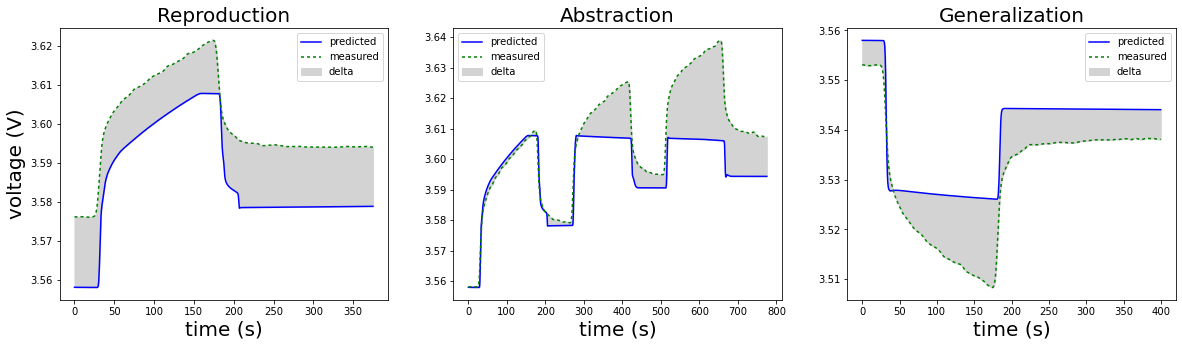

In [17]:
print('Use Case 1:', test_profiles_usecase_1)
print('Use Case 2:', test_profiles_usecase_2)
print('Use Case 3:', test_profiles_usecase_3)

lstm.test_usecases(X_train, y_train, X_case_1, y_case_1, X_case_2, y_case_2, X_case_3, y_case_3, scalers_train)

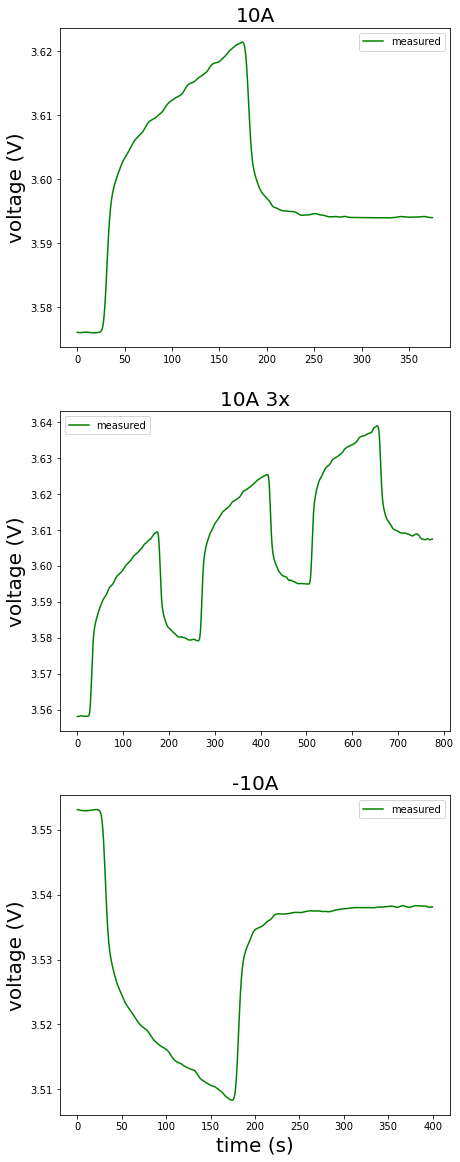

In [31]:
fig,_ = plt.subplots(figsize=(7,20))
plt.subplot(3,1,1)
y_case_1_unscaled = scalers_train.inverse_transform(y_case_1)
time_case_1 = np.arange(y_case_1_unscaled.shape[0]) * 0.25
plt.plot(time_case_1, y_case_1_unscaled, color='g', label='measured')
plt.ylabel('voltage (V)', fontsize=20)
plt.title('10A', fontsize=20)
plt.legend()
plt.subplot(3,1,2)
y_case_2_unscaled = scalers_train.inverse_transform(y_case_2)
time_case_2 = np.arange(y_case_2_unscaled.shape[0]) * 0.25
plt.plot(time_case_2, y_case_2_unscaled, color='g', label='measured')
plt.ylabel('voltage (V)', fontsize=20)
plt.title('10A 3x', fontsize=20)
plt.legend()
plt.subplot(3,1,3)
y_case_3_unscaled = scalers_train.inverse_transform(y_case_3)
time_case_3 = np.arange(y_case_3_unscaled.shape[0]) * 0.25
plt.plot(time_case_3, y_case_3_unscaled, color='g', label='measured')
plt.ylabel('voltage (V)', fontsize=20)
plt.xlabel('time (s)', fontsize=20)
plt.title('-10A', fontsize=20)
plt.legend()
plt.show()

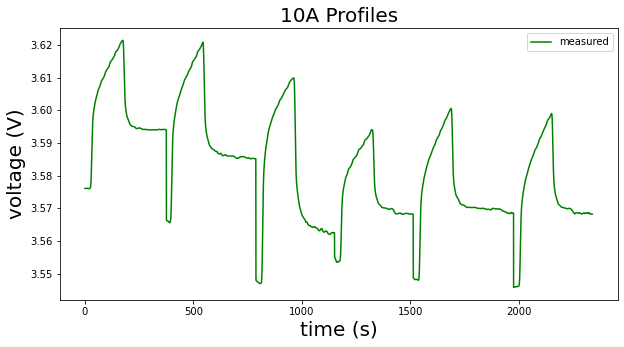

In [30]:
y_train_unscaled = scalers_train.inverse_transform(y_train)

fig,_ = plt.subplots(figsize=(10,5))
plt.subplot(1,1,1)
time_case_1 = np.arange(y_train_unscaled.shape[0]) * 0.25
plt.plot(time_case_1, y_train_unscaled, color='g', label='measured')
plt.ylabel('voltage (V)', fontsize=20)
plt.xlabel('time (s)', fontsize=20)
plt.title('10A Profiles', fontsize=20)
plt.legend()
plt.show()